# Simple implementation of Simple Traffic Light Segmentation Neural Net



# Datasets

I will create a dataset of generic shapes and train the neural net to segment the images first by colour and then by shapes.


## Colour data set

In [7]:


import numpy as np
import pandas as pd
import re


# Show images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob

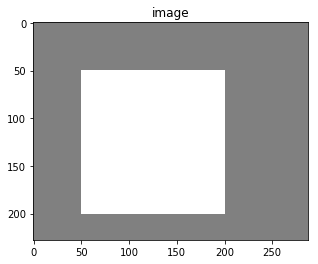

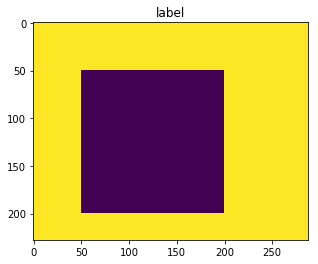

In [27]:



class TrainingImage:
    """ 
    This class handles the creation of training
    images and the associated label image
    """
    #Colors classes    
    BLACK_CLASS = 0
    WHITE_CLASS = 1
    RED_CLASS = 2
    LIME_CLASS = 3
    BLUE_CLASS = 4
    YELLOW_CLASS = 5
    CYAN_CLASS = 6
    MAGENTA_CLASS = 7
    SILVER_CLASS = 8
    GRAY_CLASS = 9
    MAROON_CLASS = 10
    OLIVE_CLASS = 11
    GREEN_CLASS = 12
    PURPLE_CLASS = 13
    TEAL_CLASS = 14
    NAVY_CLASS = 15
    
    COLOR = {
        BLACK_CLASS : (0,0,0),
        WHITE_CLASS : (255,255,255),
        RED_CLASS : (255,0,0),
        LIME_CLASS : (0,255,0),
        BLUE_CLASS : (0,0,255),
        YELLOW_CLASS : (255,255,0),
        CYAN_CLASS : (0,255,255),
        MAGENTA_CLASS : (255,0,255),
        SILVER_CLASS : (192,192,192),
        GRAY_CLASS : (128,128,128),
        MAROON_CLASS : (128,0,0),
        OLIVE_CLASS : (128,128,0),
        GREEN_CLASS : (0,128,0),
        PURPLE_CLASS : (128,0,128),
        TEAL_CLASS : (0,128,128),
        NAVY_CLASS : (0,0,128),
    }
    
    def __init__(self, size=(228,288, 3), backgd_color_class=BLACK_CLASS):
        self.size = size
        self.backgd_color_class = backgd_color_class
        self.image, self.label = self.createImageBackground()
        
    def createImageBackground(self):
        image = np.zeros(self.size, dtype=np.uint8)
        label = np.zeros(self.size[0:2], dtype=np.uint8)
        for channel in range(0, 3):
            image[:,:,channel] = TrainingImage.COLOR[self.backgd_color_class][channel]
        label[:,:] = self.backgd_color_class
        return image, label
    
    def createSquare(self, pt1, pt2, color_class=WHITE_CLASS):
        cv2.rectangle(self.image, 
                      pt1, pt2, TrainingImage.COLOR[color_class], thickness=cv2.FILLED)
        self.label[pt1[0]:pt2[0],pt1[1]:pt2[1]] =  color_class
    
trainim = TrainingImage(backgd_color_class=TrainingImage.GRAY_CLASS)
trainim.createSquare( (50,50) , (200,200))

# Plot background 
plt.imshow(trainim.image)
plt.title('image')
plt.show()

# Plot background 
plt.imshow(trainim.label)
plt.title('label')
plt.show()

['Green' 'GreenLeft' 'GreenStraight' 'Red' 'RedLeft' 'Yellow' 'off']
im.shape: (720, 1280) np.max(im): 1 np.min(im): 0


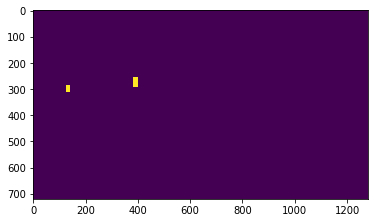

In [10]:
def preprocess_image( img, ratio = 2,size_x=224,size_y=224, x = 0, y = 0, is_label = True ):
    im = reduce_size(img, ratio, is_label = True)
    im = crop_image(im, size_x=size_x,size_y=size_y, x = x, y = y)
    if not is_label:
        im = change_light_level(im, bias_light=0.0, scale_light=1.0)
    return im

#plt.imshow( preprocess_image(image))
#plt.show()
#plt.imshow( preprocess_image(segmented_image, is_label= True))
#plt.show()

def generate_label_image(segmented_image, label_encoder):
    """ This is an image channel with 8 classes """
    label_image = np.zeros( (segmented_image.shape[0], 
                              segmented_image.shape[1] , 
                               len(label_encoder.classes_ ) + 1) , dtype=np.uint8 )
    for colour in label_encoder.classes_:
        colour_class = int(label_encoder.transform([colour,])) + 1
        label_image[:, :, colour_class] = np.uint8( segmented_image == colour_class )
    
    # Define traffic light image label (first channel)
    traffic_light = np.zeros( (segmented_image.shape[0], 
                              segmented_image.shape[1] , 2 ), dtype=np.uint8 )
    
    # Pixels not containing traffic light
    traffic_light[:, :, 0] = ( np.sum(label_image[:,:,1:], axis=2, dtype=np.uint8 ) < 1 )
    
    # Pixels containing traffic light
    traffic_light[:, :, 1] =  (traffic_light[:, :, 0]==0)
    
    return traffic_light

#plt.imshow( segmented_image == 4)
#plt.show()
print((label_encoder.classes_))
im = generate_label_image(segmented_image, label_encoder)
im = im[:,:,1]
plt.imshow( im)
print('im.shape:',im.shape, 'np.max(im):', np.max(im),  'np.min(im):', np.min(im))
#plt.imshow( im )
plt.show()

In [45]:
import yaml
import random

def generator(steps_per_epoch = 200):
    
    image_top_folder = 'bosch/dataset_additional_rgb'
    image_db_file = image_top_folder + '/additional_train.yaml'

    # Load ground truth training dataset
    image_db = yaml.load(open(image_db_file))
    
    batch_size = len(image_db)//steps_per_epoch
    print('batch_size:',batch_size)
    
    batch_idx = 0
    continue_running = True
    
    filter_only_images_region_with_traffic_light = True
    
    
    while continue_running:
        random.seed()
        image_X = []
        label_image_y = []
        
        for _ in range(len(image_db)):
            
            rand_idx = random.randint(0, len(image_db)-1)

            image_element = image_db[rand_idx]
            
            if len(image_element['boxes'])==0:
                continue
                
            # Generate portion of image
            ratio = random.uniform(1.5, 3)
            size_x=224
            size_y=224
            x = int(random.uniform(0, training_image_shape[0]/ratio-size_x-1))
            y = int(random.uniform(0, training_image_shape[1]/ratio-size_y-1))
            
            # Test if traffic light is in zoomed image
            traffic_light_in_image = False 
            margin = 5
            for box in image_element['boxes']:
                x_start_in_range = box['x_min'] < x - margin and box['x_max'] > x + margin
                x_end_in_range = box['x_min'] <= x + size_x - margin and box['x_max'] > x + size_x + margin
                y_start_in_range = box['y_min'] < y - margin and box['y_max'] > y + margin
                y_end_in_range = box['y_min'] < y + size_y - margin and box['y_max'] > y + size_y + margin
                # If any of the corners of the boxes is in image, then we can use the image
                if (x_start_in_range and (y_start_in_range or y_end_in_range) ) or \
                (x_end_in_range and (y_start_in_range or y_end_in_range) ):
                    #print('POSSIBLE: Traffic light in image')
                    traffic_light_in_image = True
                    break
                else:
                    continue
                    
            # Otherwise we don't use the image
            if not  traffic_light_in_image :
                continue
                
            image_path = image_top_folder + image_element['path'].replace('./','/')
            image = cv2.cvtColor( cv2.imread( image_path), cv2.COLOR_BGR2RGB )

            
            image_train = preprocess_image( image, ratio = ratio, size_x= size_x,size_y=size_y, x = x, y = y) 
            
            
            # Generate portion of label image
            segmented_image = segment_image(image_element, image, label_encoder)
            segmented_image = preprocess_image(segmented_image, is_label= True)
            
            # Split class labels accross different channels
            label_image = generate_label_image(segmented_image, label_encoder)
            
            #TODO : Remove this debug point
            if np.any(segmented_image) and filter_only_images_region_with_traffic_light:
                batch_idx += 1 
                label_image_y.append(label_image)
                image_X.append( image_train )
                #print('YES: Traffic light in image')
            elif not filter_only_images_region_with_traffic_light:
                batch_idx += 1 
                label_image_y.append(label_image)
                image_X.append( image_train )
            else:
                #print('NO : No traffic light in image')
                pass
                
                
            if batch_idx >= batch_size :
                X = np.array(image_X).astype(np.uint8)
                y = np.array(label_image_y).astype(np.uint8)
                image_X = []
                label_image_y = []
                batch_idx = 0
                yield (X, y)
            
        #continue_running = False
    #return (image_X, segmented_image, label_image)

# (image, label_image) = generator()
# plt.imshow( image)
# plt.show()

# plt.imshow(np.sum(label_image[:, :, 1:7]*10, axis=2 ) + label_image[:, :, 1]*5)
# plt.show()


# Model
The original paper uses VGG for implementing the detector.


TODO : Will try experimenting with Xception and MobileNet  
https://keras.io/applications/#usage-examples-for-image-classification-models


In [41]:
# Extract features from an arbitrary intermediate layer with VGG19

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

base_model = VGG16(weights='imagenet', input_shape=(224, 224, 3),pooling=None, include_top=False)


print('Pre-trained model loaded.')


#from keras.utils import plot_model
#plot_model(base_model, to_file='model.png')
base_model.summary()

for layer in base_model.layers:
    layer.trainable = False



Pre-trained model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)  

In [42]:
# Get input dimensions
input_height = base_model.layers[0].input_shape[1]
input_width = base_model.layers[0].input_shape[2]

In [43]:
# Extract pooling layers out of VGG-16
input_height*input_width
#num_classes = len(label_encoder.classes_) + 1
num_classes = 2

from keras.layers import Dense, Conv2D, UpSampling2D, Activation
from keras.layers import Conv2DTranspose, Add, Flatten, Lambda
from keras.layers import BatchNormalization, Reshape, Permute, Dropout
from keras import backend as K
from keras import regularizers

# Layer 5
layer_5_1x1 = Conv2D(num_classes, 1, padding='same', name='convpool_5_1x1',
               activation='selu')(base_model.get_layer('block5_pool').output)

up_layer_5 = Conv2DTranspose(num_classes, (3, 3), activation='selu',
                            padding='same', strides=(2,2)  )(layer_5_1x1)

#up_layer_5_bn = BatchNormalization(axis=3, name='up_layer_5_bn')(up_layer_5)

# Layer 4
layer_4_1x1 = Conv2D(num_classes, 1, padding='same', name='convpool_4_1x1',
               activation='selu')(base_model.get_layer('block4_pool').output)

merge_4_and_5 = Add()([up_layer_5, layer_4_1x1])


up_layer_4_and_5 = Conv2DTranspose(num_classes, (3, 3), activation='selu',
                            padding='same', strides=(2,2))(merge_4_and_5)

up_layer_4_and_5 = BatchNormalization(axis=3, name='up_layer_4_and_5_bn')(up_layer_4_and_5)

# Layer 3
layer_3_1x1 = Conv2D(num_classes, 1, padding='same', name='convpool_3_1x1',
               activation='selu')(base_model.get_layer('block3_pool').output)

merge_3_to_5 = Add()([up_layer_4_and_5, layer_3_1x1])

up_layer_3_to_5 = Conv2DTranspose(num_classes, (3, 3), activation='selu',
                            padding='same', strides=(2,2)  )(merge_3_to_5)



# Layer 2
layer_2_1x1 = Conv2D(num_classes, 1, padding='same', name='convpool_2_1x1',
               activation='selu')(base_model.get_layer('block2_pool').output)

merge_2_to_5 = Add()([up_layer_3_to_5, layer_2_1x1])



up_layer_2_to_5 =Conv2DTranspose(num_classes, (3, 3), 
                                      activation='selu',
                            padding='same', strides=(2,2) ,
                                      name='up_layer_2_to_5')(merge_2_to_5)


up_layer_2_to_5 = BatchNormalization(axis=3, 
                                        name='up_layer_2_to_5_bn')(up_layer_2_to_5)

# Layer 1
layer_1_1x1 = Conv2D(num_classes, 1, padding='same', name='convpool_1_1x1',
               activation='selu')(base_model.get_layer('block1_pool').output)

layer_1_1x1 = Dropout(0.95)(layer_1_1x1)

merge_1_to_5 = Add()([up_layer_2_to_5, layer_1_1x1])

up_layer_1_to_5 =Conv2DTranspose(num_classes, (3, 3), 
                                      activation='selu',
                            padding='same', strides=(2,2) ,
                                      name='final_up')(merge_1_to_5)





def depth_softmax(matrix):
    sigmoid = lambda x: 1 / (1 + K.exp(-x))
    sigmoided_matrix = sigmoid(matrix)
    sum_sig = K.sum(sigmoided_matrix, axis=3)
    sum_sig_reshaped = K.reshape(sum_sig,(-1,input_height,input_height,1))
    repeat = num_classes
    sum_sigmoided_repeated = K.repeat_elements(sum_sig_reshaped, repeat, axis=3)
    softmax_matrix = sigmoided_matrix / sum_sigmoided_repeated
    return softmax_matrix

seg_out = Lambda(depth_softmax, name='seg_out')(up_layer_1_to_5)

# Build a classifier model to put on top of the convolutional model

model = Model(inputs=base_model.input, outputs=seg_out)



from keras.utils import plot_model
plot_model(model, to_file='model.png')

#for i in model.layers:
#    print(i.trainable)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [46]:
from keras import optimizers
optimizer_selected = optimizers.Adam(lr=1e-3)

model.compile(optimizer=optimizer_selected, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

steps_per_ep = 10
history = model.fit_generator(generator(steps_per_epoch=steps_per_ep), steps_per_ep, epochs=50)


Epoch 1/50
batch_size: 21
10/10 [==============================] - 8s 830ms/step - loss: 0.7016 - categorical_accuracy: 0.6106
Epoch 2/50
10/10 [==============================] - 7s 659ms/step - loss: 0.6856 - categorical_accuracy: 0.6232
Epoch 3/50
10/10 [==============================] - 7s 694ms/step - loss: 0.6721 - categorical_accuracy: 0.6444
Epoch 4/50
10/10 [==============================] - 7s 681ms/step - loss: 0.6585 - categorical_accuracy: 0.7185
Epoch 5/50
10/10 [==============================] - 7s 702ms/step - loss: 0.6442 - categorical_accuracy: 0.7517
Epoch 6/50
10/10 [==============================] - 7s 731ms/step - loss: 0.6312 - categorical_accuracy: 0.7627
Epoch 7/50
10/10 [==============================] - 7s 713ms/step - loss: 0.6180 - categorical_accuracy: 0.7744
Epoch 8/50
10/10 [==============================] - 7s 697ms/step - loss: 0.6028 - categorical_accuracy: 0.7835
Epoch 9/50
10/10 [==============================] - 7s 730ms/step - loss: 0.5885 - catego

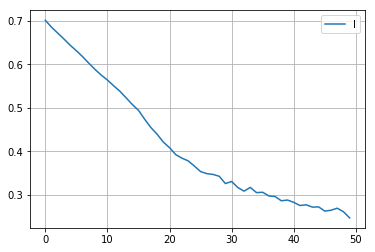

In [47]:
# Plot loss function
plt.plot(history.epoch,history.history['loss'])
plt.legend(('loss'))
plt.grid('on')
plt.show()


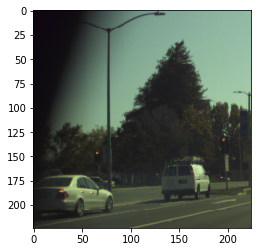

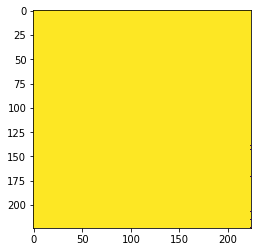

In [48]:
image_path = 'bosch/dataset_additional_rgb/rgb/additional/2015-10-05-10-55-33_bag/57058.png'
img = cv2.cvtColor( cv2.imread( image_path), cv2.COLOR_BGR2RGB )
img = preprocess_image(img)

plt.imshow( img)
plt.show()

seg= model.predict(img.reshape(1,224,224,3))

seg = seg.reshape(224,224,2)
plt.imshow( seg[:,:,0]>seg[:,:,1])
plt.show()

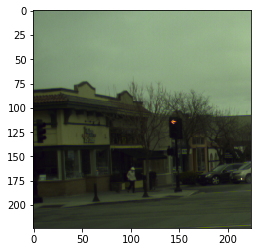

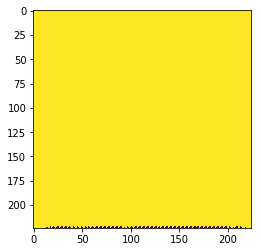

(224, 224, 3)


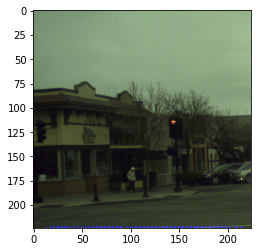

In [39]:
image_path = 'bosch/dataset_train_rgb_zip/rgb/train/2017-02-03-11-44-56_los_altos_mountain_view_traffic_lights_bag/208772.png'

img = cv2.cvtColor( cv2.imread( image_path), cv2.COLOR_BGR2RGB )
img = preprocess_image(img)

plt.imshow( img)
plt.show()

seg= model.predict(img.reshape(1,224,224,3))

seg = seg.reshape(224,224,2)


seg = seg.reshape(224,224,2)
plt.imshow( seg[:,:,0]>seg[:,:,1])
plt.show()

prediction = np.zeros(img.shape, dtype=np.uint8)
print(prediction.shape)
prediction[:,:,2] = ((seg[:,:,0]<seg[:,:,1]).astype(np.uint32) * 300).clip(0,255).astype(np.uint8)

combine_images = (img.astype(np.uint16) + prediction.astype(np.uint16)).clip(0,255).astype(np.uint8)
plt.imshow( combine_images )
plt.show()